Get 3rd harmonic wrt first (output from Thrdharmon.ipynb) as 1 number per subject, then look for gender differences

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import nibabel as nib
import matplotlib.pyplot as plt
import os


In [2]:
# get subjects from subjects.txt:
# Path to your subject list file
subjects_file = r"D:\HCP_vessel_files\subjects.txt"

# Read all IDs into a Python list
with open(subjects_file, "r") as f:
    subjects = [line.strip() for line in f if line.strip()]
print("Loaded", len(subjects), "subjects:")

# subjects = subjects[:10]
# subjects = subjects[7:100] 
print(subjects) 

Loaded 190 subjects:
['100307', '101309', '102008', '102311', '103111', '103414', '103818', '105014', '107422', '108828', '109123', '110411', '111716', '113619', '113821', '113922', '114419', '115320', '116524', '118528', '118932', '120212', '121618', '123420', '124220', '124826', '127630', '128127', '129533', '130013', '132118', '133827', '136833', '137027', '137128', '137936', '138231', '140117', '140824', '142424', '142828', '143325', '144832', '145531', '146331', '146432', '148941', '150423', '150726', '151627', '153833', '154734', '154936', '155635', '156637', '158035', '159138', '161630', '161731', '162733', '163331', '164131', '165032', '167743', '168341', '169343', '169444', '170934', '172130', '172938', '173536', '175035', '177645', '178950', '179346', '180129', '180836', '180937', '181232', '183034', '185139', '186141', '187143', '187547', '188347', '189349', '191033', '191437', '191841', '192540', '192843', '194140', '194847', '195849', '197348', '198855', '199150', '199251'

In [3]:
# register a volume from MNI -> fMRI 

import ants
def MNI_to_fMRI(MNI_img_path, subjectid, interpolator="nearestNeighbor"):    
    transform_dir = fr"D:\hcp_processed\{subjectid}\transforms" # output directory for transformations
    affine_mat_path = fr"{transform_dir}\fMRI_to_T1w_0GenericAffine.mat"
    affine_mni_path = fr"{transform_dir}\T1w_to_MNI_0GenericAffine.mat"
    # need the inverse warp? 
    warp_t12mni_inv = fr"{transform_dir}\T1w_to_MNI_1InverseWarp.nii.gz"
    warp_field_path = fr"{transform_dir}\T1w_to_MNI_1Warp.nii.gz" # use inverse wrap or not? Need to check registration 

    # reference_img = ants.image_read(fr"{path}/fmri_sen_ref.nii")  # reference fMRI space
    reference_img = ants.image_read(fr"D:\hcp_processed\{subjectid}\motion_corrected\mean_fmri.nii.gz")

    # need to save the nifti file to load it in as an ANTs file (seriously?)
    moving_img = ants.image_read(MNI_img_path)  # MNI mask

    transformed = ants.apply_transforms(
        fixed=reference_img,
        moving=moving_img,
        transformlist=[
            affine_mat_path,            # fMRI -> T1w affine, inverted automatically
            affine_mni_path,            # T1w -> MNI affine, inverted automatically
            # warp_field_path             # T1w -> MNI warp, non-linear, inverted automatically
            warp_t12mni_inv
        ],
        whichtoinvert=[True, True, False],  # invert affines, warps handled internally
        # interpolator="nearestNeighbor"     # because it's a mask # NEED THIS AS INPUT IF USING A BINARY MASK LIKE PULSE RELIABILITY THRESHOLDED
        interpolator=interpolator     # for non-binary mask # 'linear' for non-binary mask, 'nearestNeighbor' for binary mask
    )
    
    transformed_data = transformed.numpy()
    reference_nib = nib.load(fr"D:\hcp_processed\{subjectid}\motion_corrected\mean_fmri.nii.gz")
    fMRI_img = nib.Nifti1Image(transformed_data, affine=reference_nib.affine, header=reference_nib.header)

    # # Need to check overlap of the mask with the native fMRI space:
    # cut_coords = (0, 0, 0)  # or nilearn can compute them automatically if you want
    # plotting.plot_stat_map(fMRI_img, bg_img=reference_nib, threshold=0.1, display_mode='ortho', cut_coords=cut_coords)
    # plotting.show()

    return fMRI_img


In [4]:
# use a mask? Vessel and brain mask first? - compute average 3/1 within it
# make it in MNI, then go to native fMRI, compute, 3/1 and 2/1, then spit out 1 value per subject
# save that in csv file to link it to demographic information later

In [5]:
# register a volume from MNI -> fMRI 

import ants
def MNI_to_fMRI(MNI_img_path, subjectid, interpolator="nearestNeighbor"):    
    transform_dir = fr"D:\hcp_processed\{subjectid}\transforms" # output directory for transformations
    affine_mat_path = fr"{transform_dir}\fMRI_to_T1w_0GenericAffine.mat"
    affine_mni_path = fr"{transform_dir}\T1w_to_MNI_0GenericAffine.mat"
    # need the inverse warp? 
    warp_t12mni_inv = fr"{transform_dir}\T1w_to_MNI_1InverseWarp.nii.gz"
    warp_field_path = fr"{transform_dir}\T1w_to_MNI_1Warp.nii.gz" # use inverse wrap or not? Need to check registration 

    # reference_img = ants.image_read(fr"{path}/fmri_sen_ref.nii")  # reference fMRI space
    reference_img = ants.image_read(fr"D:\hcp_processed\{subjectid}\motion_corrected\mean_fmri.nii.gz")

    # need to save the nifti file to load it in as an ANTs file (seriously?)
    moving_img = ants.image_read(MNI_img_path)  # MNI mask

    transformed = ants.apply_transforms(
        fixed=reference_img,
        moving=moving_img,
        transformlist=[
            affine_mat_path,            # fMRI -> T1w affine, inverted automatically
            affine_mni_path,            # T1w -> MNI affine, inverted automatically
            # warp_field_path             # T1w -> MNI warp, non-linear, inverted automatically
            warp_t12mni_inv
        ],
        whichtoinvert=[True, True, False],  # invert affines, warps handled internally
        # interpolator="nearestNeighbor"     # because it's a mask # NEED THIS AS INPUT IF USING A BINARY MASK LIKE PULSE RELIABILITY THRESHOLDED
        interpolator=interpolator     # for non-binary mask # 'linear' for non-binary mask, 'nearestNeighbor' for binary mask
    )
    
    transformed_data = transformed.numpy()
    reference_nib = nib.load(fr"D:\hcp_processed\{subjectid}\motion_corrected\mean_fmri.nii.gz")
    fMRI_img = nib.Nifti1Image(transformed_data, affine=reference_nib.affine, header=reference_nib.header)

    # # Need to check overlap of the mask with the native fMRI space:
    # cut_coords = (0, 0, 0)  # or nilearn can compute them automatically if you want
    # plotting.plot_stat_map(fMRI_img, bg_img=reference_nib, threshold=0.1, display_mode='ortho', cut_coords=cut_coords)
    # plotting.show()

    return fMRI_img


MNI_template.shape (197, 233, 189)


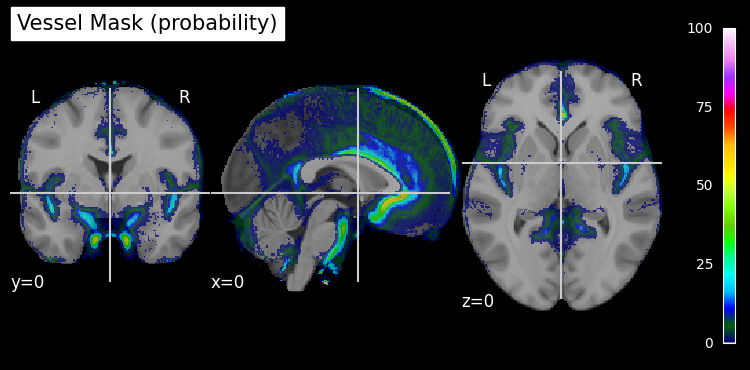

In [6]:
from nilearn.image import resample_to_img
from nilearn import plotting

MNI_template_path = fr"D:\Templates\mni_template.nii"
MNI_template = nib.load(MNI_template_path)
print(f"MNI_template.shape {MNI_template.shape}")

# plot the pulse reliability mask with the MNI vessel mask and compute the DICE. 
# change the reliability threshold to find the one with the maximum DICE and show that. 
# vessel mask: 
vs_img = nib.load(r"C:\DocumentsPC\DATA\Templates\vesselProbabilities.nii.gz")
# plotting.plot_roi(vs_img, bg_img=MNI_template, title="Vessel Mask (probability)", display_mode='ortho', cut_coords=(0, 0, 0), colorbar=True)
# plotting.show()
vs_data = vs_img.get_fdata() # Optional: Threshold to make binary mask
vs_img_resampled = resample_to_img(source_img=vs_img, target_img=MNI_template, interpolation='continuous')
# plotting.plot_roi(vs_img_resampled, bg_img=mni_template, title="Vessel Mask (probability)", display_mode='ortho', cut_coords=(0, 0, 0), colorbar=True)
# plotting.show() # check resampled vessel mask
vs_data = vs_img_resampled.get_fdata()
vs_data = vs_img_resampled.get_fdata()
vs_data = np.clip(vs_data, 0, 100)  # if 100 is expected max
vs_data = vs_data / 100.0
plotting.plot_roi(nib.Nifti1Image(vs_data*100,vs_img_resampled.affine), bg_img=MNI_template, title="Vessel Mask (probability)", display_mode='ortho', cut_coords=(0, 0, 0), colorbar=True)
plotting.show() # check resampled vessel mask
# Saving the within-mni vessel mask
vs_output_path = r"D:\Templates\vs_data_resampled.nii.gz"
# Create a new NIfTI image with the correct affine and header
vs_img_out = nib.Nifti1Image(vs_data, affine=vs_img_resampled.affine, header=vs_img_resampled.header)
# Save the image
nib.save(vs_img_out, vs_output_path)




In [ ]:
results = [] 
nbins = 40
B = 5
high_pass = 0.0042

for subjectid in subjects:
    print(f"subject {subjectid}")

    A1_nifti = nib.load(fr"D:\hcp_processed\{subjectid}\harmBin1_nbins30.nii.gz") 
    A2_nifti = nib.load(fr"D:\hcp_processed\{subjectid}\harmBin2_nbins30.nii.gz")
    A3_nifti = nib.load(fr"D:\hcp_processed\{subjectid}\harmBin3_nbins30.nii.gz")
    A4_nifti = nib.load(fr"D:\hcp_processed\{subjectid}\harmBin4_nbins30.nii.gz")
    A5_nifti = nib.load(fr"D:\hcp_processed\{subjectid}\harmBin5_nbins30.nii.gz")
    A6_nifti = nib.load(fr"D:\hcp_processed\{subjectid}\harmBin6_nbins30.nii.gz")


    A1_data = A1_nifti.get_fdata()
    A2_data = A2_nifti.get_fdata()
    A3_data = A3_nifti.get_fdata()
    A4_data = A4_nifti.get_fdata()
    A5_data = A5_nifti.get_fdata()
    A6_data = A6_nifti.get_fdata()
    # A7_data = A7_nifti.get_fdata()

    fMRI_vessel = MNI_to_fMRI(vs_output_path, subjectid, interpolator="linear") 
    fMRI_vessel_data = fMRI_vessel.get_fdata() > 0.05 # binary vessel mask

    # r2_path = fr'D:\hcp_processed\{subjectid}\PulseR2Linear_nbins{nbins}_B{B}_HPC{high_pass}_RPs{12}.nii.gz'
    # r2_nifti = nib.load(r2_path)
    # for group reliability mask instead: 
    r2_group = fr'D:\hcp_processed\GroupResults\PulseR2Linear_nbins{nbins}_B{B}_HPC{high_pass}_RPs{12}_190subject.nii.gz'
    r2_nifti = MNI_to_fMRI(r2_group, subjectid, interpolator="linear") 
    r2_data_mask = r2_nifti.get_fdata() > 0.1 # 0.4. 0.1?
    combined_mask = fMRI_vessel_data & r2_data_mask
    
    # compute A1_nifti within the mask, A2/A1 within mask, and A3/A1 within the mask 
    # A1_vs = A1_nifti.get_fdata() * fMRI_vessel_data
    A1_values_in_mask = A1_data[combined_mask]

    mean_A1 = np.mean(A1_values_in_mask)

    # # get A1 normalized to DC:
    # mean_fmri = nib.load(fr"D:\hcp_processed\{subjectid}\motion_corrected\mean_fmri.nii.gz")
    # mean_fmri_data = mean_fmri.get_fdata()
    # DC = np.mean(mean_fmri_data[fMRI_vessel_data])

    mean_A1DC = np.mean(A1_data[combined_mask])
    mean_A2 = np.mean(A2_data[combined_mask])
    mean_A3 = np.mean(A3_data[combined_mask])
    mean_A4 = np.mean(A4_data[combined_mask])
    mean_A5 = np.mean(A5_data[combined_mask])
    mean_A6 = np.mean(A6_data[combined_mask])
    # mean_A7A1 = np.mean(A7A1[combined_mask])

    print(f"Mean A1 within vessel mask = {mean_A1}")
    # print(f"Mean A1 within vessel mask (normalized to original DC) = {mean_A1DC}")
    print(f"Mean A2 within vessel mask = {mean_A2}")
    print(f"Mean A3 within vessel mask = {mean_A3}")
    print(f"Mean A4 within vessel mask = {mean_A4}")
    print(f"Mean A5 within vessel mask = {mean_A5}")
    print(f"Mean A6 within vessel mask = {mean_A6}")
    # print(f"Mean A7/A1 within vessel mask = {mean_A7A1}")

    results.append({
        # "Subject": subjectid,
        # "A1": mean_A1,
        # "A1DC": mean_A1,
        # "A2A1": mean_A2,
        # "A3A1": mean_A3,
        # "A4A1": mean_A4,
        # "A5A1": mean_A5,
        # "A6A1": mean_A6,
        # # "A7A1": mean_A7A1
        "Subject": subjectid,
        "A1": mean_A1,
        "A1": mean_A1,
        "A2": mean_A2,
        "A3": mean_A3,
        "A4": mean_A4,
        "A5": mean_A5,
        "A6": mean_A6,
    })



subject 100307
Mean A1 within vessel mask = 0.008688173893737194
Mean A2 within vessel mask = 0.0040677819083139504
Mean A3 within vessel mask = 0.0022532667140249866
Mean A4 within vessel mask = 0.0017597148226808927
Mean A5 within vessel mask = 0.0016106327791253951
Mean A6 within vessel mask = 0.0013407449928968063
subject 101309
Mean A1 within vessel mask = 0.021133607250791712
Mean A2 within vessel mask = 0.009722222863743671
Mean A3 within vessel mask = 0.006519050319795451
Mean A4 within vessel mask = 0.00464316779805369
Mean A5 within vessel mask = 0.0043995793677740645
Mean A6 within vessel mask = 0.0039510763393960525
subject 102008
Mean A1 within vessel mask = 0.009954330112241788
Mean A2 within vessel mask = 0.0040990068828583364
Mean A3 within vessel mask = 0.0036484554725491336
Mean A4 within vessel mask = 0.003224258142326613
Mean A5 within vessel mask = 0.0024172369638916693
Mean A6 within vessel mask = 0.002734951219647314
subject 102311
Mean A1 within vessel mask = 0.

In [9]:
import os
from pathlib import Path
import pandas as pd

# OUT_CSV = Path(r"D:\hcp_processed\moreharmon1numDC.csv")
OUT_CSV = Path(r"D:\hcp_processed\Harm1numBinR2GDC.csv")

def save_batch(subject_rows, out_csv=OUT_CSV):
    """
    subject_rows: list of dicts like
      {"subject_id": "100307", "CoW_mean_amp": 1.23, "Baseline_median_amp": 0.45, "CoW_pulsatility_norm": 2.73}
    Appends new subjects; replaces rows for subjects that already exist.
    """
    df_batch = pd.DataFrame(subject_rows)
    df_batch["Subject"] = df_batch["Subject"].astype(int)   # always string

    if out_csv.exists():
        df_existing = pd.read_csv(out_csv)
        # Concatenate and keep the last occurrence per subject_id (i.e., overwrite old with new)
        df_merged = pd.concat([df_existing, df_batch], ignore_index=True)
        # df_merged = df_merged.sort_values("subject_id").drop_duplicates("subject_id", keep="last")
        df_merged = df_merged.sort_values("Subject").drop_duplicates("Subject", keep="last")
    else:
        # df_merged = df_batch.sort_values("subject_id")
        df_merged = df_batch.sort_values("Subject")

    # Atomic-ish write (avoid corrupting file if something crashes mid-write)
    tmp = out_csv.with_suffix(".tmp.csv")
    df_merged.to_csv(tmp, index=False)
    tmp.replace(out_csv)   # renames tmp -> final

    print(f"Saved {len(df_batch)} subjects (upserted). Total rows now: {len(df_merged)} → {out_csv}")


save_batch(results)


Saved 190 subjects (upserted). Total rows now: 190 → D:\hcp_processed\Harm1numBinR2GDC.csv
